# Assignment 2: Linear Models and Regularization

**Saurabh Kumar** <br>
**Roll No**: 22B3905<br>
**Video Link:** 
[Google Drive](https://drive.google.com/drive/folders/1JLahbZPSK8iweD9x25tylaz696QoMSGq?usp=share_link)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns

In [2]:
def gen_input_matrix(N:int, S, sigma=0.1):
    """Generates the input data matrix X of size NxD
    
    Parameters:
        N: int
        S: [MxD]
    Returns:
        X : a NxD matrix
    """
    mu = 0
    N = int(N)
    S_array = np.array(S) # convert S into an numpy 'array' object
    M, D = S.shape
    generator_matrix = np.zeros((N, M)) 

    for i  in range(N): # fill all the rows with normal distribution
        generator_matrix[i] = np.random.normal(mu, sigma, M)


    X = np.matmul(generator_matrix,S) # multiply generator_matrix and S
    return X

In [3]:
def gen_target_vector(X, w, sigma=0.1):
    """Generates the target vector t of size Nx1
    
    Parameters:
        X : Data matrix of size NxD
        w : weight vector of [float]*(D+1)
    Returns:
        t: [int]*N
    """

    X = np.array(X) # convert into np array if not already
    N, D = X.shape

    if not D+1 == len(w):
        print(D, len(w))
        raise ValueError("Invalid weight vector, ensure the dimensions of X and w match.\n")

    t = np.matmul(X, w[1:])
    w_zero = [w[0]]*N
    noise = np.random.normal(0, sigma, N)
    t = t+ w_zero + noise # add the bias and the noise
    
    return t

    
        

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1999/1999 [01:20<00:00, 24.88it/s]


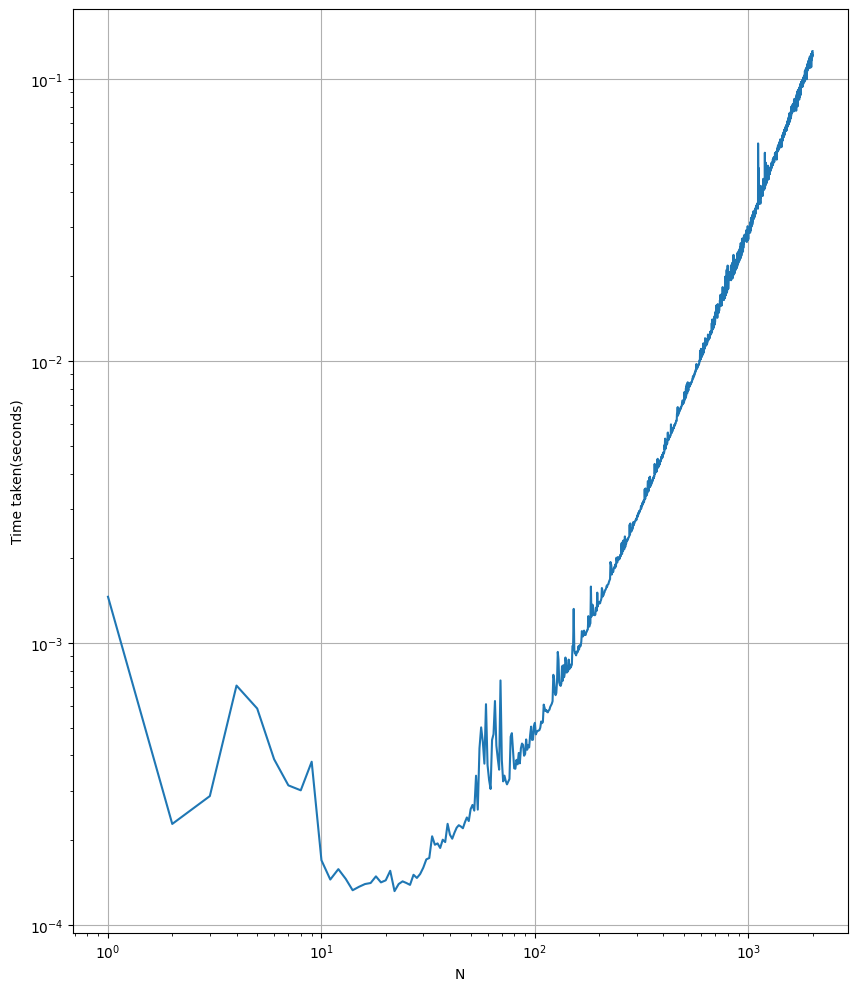

In [35]:
# Examiniming the behaviour of analytical solver basesd on pseudo-inverse(pinv) in numpy.linalg package wrt
# to the size matrix
import time 
from numpy.linalg import pinv

D = 10

# A decorator to measure time elapsed for the function
def time_wrapper(func):
    def wrapper(*args, **kwargs):
        start_time = time.time() 
        result = func(*args, **kwargs) 
        end_time = time.time()    
        elapsed_time = end_time - start_time
        return result, elapsed_time # return the time
    return wrapper


@time_wrapper
def analytical_solver(N, D=10):
    S = np.eye(N, D)
    X = gen_input_matrix(N, S)
    w = np.random.rand(D+1)
    
    Y = gen_target_vector(X,w, 0.1)

    X_pinv = pinv(X)
    solution = np.matmul(X_pinv, Y)
    
    return solution

def plot_execution_with_time(N_range:int):
    times = []
    n_vals = [i for i in range(1, N_range)]
    for n in tqdm(range(1, N_range)):
        pinv, execution_time = analytical_solver(n)
        times.append(execution_time)

    plt.figure(figsize=(10, 12))
    plt.plot(n_vals, times, marker=' ')
    plt.ylabel('Time taken(seconds)')
    plt.xlabel('N')
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    plt.show()

plot_execution_with_time(2000)     


**Observation**:
The time taken shows a sharp increase around  N \approx 500 . This spike may be attributed to the way matrix multiplication and pseudoinverse (pinv) operations are handled in the NumPy package. As matrix size grows, computational complexity rises, leading to a significant jump in time when handling larger input sizes.

## Calculating NRMSE - Normalized Root Mean Square Error

Let $\mathbf{t} = \begin{pmatrix} t_1 \\ \vdots \\ t_n \end{pmatrix}$ and $\mathbf{y} = \begin{pmatrix} y_1 \\ \vdots \\ y_n \end{pmatrix}$ represent the true and predicted values, respectively. The normalized root mean squared error (NRMSE) is calculated as:

$$
\text{NRMSE} = \frac{\sqrt{\frac{1}{n} \sum_{i=1}^{n} (t_i - y_i)^2}}{y_{\text{max}} - y_{\text{min}}}
$$

Where:
- $n$ is the number of samples,
-  $t_i$ is the true value of the $i$-th sample,
- $y_i$ is the predicted value of the \(i\)-th sample,


In case  $y_{\text{max}} = y_{\text{min}}$, the NRMSE is calculated as:

$$
\text{NRMSE} = \frac{\text{RMSE}}{y_{\text{max}}^n}
$$

where RMSE is the root mean squared error.

In [7]:
def calculate_norm_rse(t, y):
    """ Returns the normalized root mean squared error"""
    
    if not len(t) == len(y):
        raise ValueError('Invalid inputs, len(t) != len(y)')
    
    n = len(t)
    squared_error = 0
    y_min = min(y)
    y_max = max(y)

    for i in range(n):
        squared_error += (t[i]-y[i])**2

    rmse = np.sqrt(squared_error/n)
    if y_max == y_min:
        return rmse/(y_max**n)
    
    nrmse = rmse/(y_max - y_min)

    return nrmse


##  Gradient of MSE


$$
\mathbf{Y} = \begin{pmatrix} y_1 \\ \vdots \\ y_N \end{pmatrix}, \quad \mathbf{X} = \begin{pmatrix} x_{11} 
& \dots & x_{1D} \\ \vdots & \ddots & \vdots \\ x_{N1} & \dots & x_{ND} \end{pmatrix}
$$

Let $\mathbf{e} = \mathbf{Y} - \mathbf{X}\mathbf{w} - \mathbf{w_{0}}$, since we are not augmenting $\mathbf{X}$, and the mean squared error can be written as:

$$
L(\mathbf{w}) = \frac{1}{2N} \sum_{i=1}^{N} \left( y_i - \mathbf{x}_i^T \mathbf{w} -\mathbf{w_{0}} \right)^2 = \frac{1}{2N} \mathbf{e}^T \mathbf{e}
$$

Then, the gradient of the loss function is given by:

$$
\nabla L(\mathbf{w}) = -\frac{1}{N} \mathbf{X}^T \mathbf{e}
$$

Hence we take parameters $\mathbf{X}$,  $\mathbf{Y}$ and $\mathbf{w}$ as inputs return the gradient i.e $\nabla L(\mathbf{w})$ using above expressions

In [5]:
def calculate_mse_gradient(X, Y, w):
    """ Returns the gradient of mean squared error(MSE) wrt weights of linear regression"""
    X = np.array(X)
    N, D = X.shape
    Y = np.array(Y)
    bias_term = [w[0]]*N
    w = np.array(w[1:]) # exclude the bias
    

    e = Y - np.matmul(X, w) - bias_term  # WARNING: Check if the bias term is excluded properly

    XTe = np.matmul(np.transpose(X), e)

    del_lw = -1/N*XTe
    return del_lw
    

In [12]:


def L2_norm(w):
    n = len(w)
    L2 =0
    for i in w:
        L2+= i**2
    return L2

def L1_norm(w):
    L1 = 0

    for i in w:
        L1+= abs(i)

    return L1

# Gradient Descent on MSE + $\lambda_1 L_1$ +  $\lambda_2 L_3$

Given the input data matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ and the target vector $\mathbf{y} \in \mathbb{R}^m$, we aim to minimize the loss function $L(\mathbf{w})$, which includes Mean Squared Error (MSE), L1 regularization (Lasso), and L2 regularization (Ridge).

### Loss Function:

$$
L(\mathbf{w}) = \frac{1}{2m} \sum_{i=1}^{m} \left( y_i - \left( \mathbf{x}_i^T \mathbf{w} + w_0 \right) \right)^2 + \lambda_1 \sum_{j=1}^{n} |w_j| + \lambda_2 \sum_{j=1}^{n} w_j^2
$$

Where:
- $\mathbf{w} = [w_1, w_2, \ldots, w_n]^T$ is the weight vector.
- $w_0$ is the bias term (not regularized).
- $\lambda_1$ is the L1 regularization coefficient.
- $\lambda_2$ is the L2 regularization coefficient.

### Gradient of the Loss Function:

For the weights $\mathbf{w}$, the gradient of the loss function is computed as:

$$
\nabla L(\mathbf{w}) = -\frac{1}{m} \mathbf{X}^T (\mathbf{y} - \mathbf{X}\mathbf{w} - w_0) + \lambda_1 \, \text{sign}(\mathbf{w}) + 2 \lambda_2 \mathbf{w}
$$

For the bias term $w_0$:

$$
\nabla L(w_0) = -\frac{1}{m} \sum_{i=1}^{m} \left( y_i - \mathbf{x}_i^T \mathbf{w} - w_0 \right)
$$

### Gradient Descent Update Rule:

The parameters are updated iteratively using the learning rate $\alpha$:

$$
w_0^{(k+1)} = w_0^{(k)} - \alpha \nabla L(w_0)
$$

$$
\mathbf{w}^{(k+1)} = \mathbf{w}^{(k)} - \alpha \nabla L(\mathbf{w})
$$

### Stopping Criterion: 

The gradient descent stops when the change in the loss function is smaller than a threshold $\epsilon$:

$$
|L^{(k+1)} - L^{(k)}| < \epsilon
$$


In [8]:
def gradient_descent_l1_l2(X, y, alpha=0.01, lambda1=0.01, lambda2=0.01, max_iters=1000, tol=1e-6):
    """
    Perform gradient descent for linear regression with L1 (Lasso) and L2 (Ridge) regularization.

    Parameters:
        - X: Input matrix (m x n) without bias column.
        - y: Output vector (m x 1).
        - alpha: Learning rate.
        - lambda1: L1 regularization strength.
        - lambda2: L2 regularization strength.
        - max_iters: Max number of iterations.
        - tol: Stopping criterion tolerance. [1]

    Returns:
        - theta: Optimized parameters (including bias term).
        - cost_history: Cost function values per iteration.
    """
    m, n = X.shape

   
    theta = np.zeros(n + 1)  # Initialize parameters (theta will be (n+1) due to the bias term)
    cost_history = []

    for iteration in range(max_iters):
        
        h = np.dot(X, theta[1:]) + theta[0] # Compute the prediction: X @ theta[1:] + theta[0] for bias

        error = h - y

        
        gradient_mse = (1/m) * np.dot(X.T, error) # Compute the gradient of the MSE         
        gradient_w0 = (1/m) * np.sum(error)  # Compute the gradient for the bias (w0) separately

        gradient_l1 = lambda1 * np.sign(theta[1:])  # Compute the gradient for the bias (w0) separately
        gradient_l2 = 2 * lambda2 * theta[1:] # Compute the gradient of the L2 term

        gradient_l1_wo = lambda1*np.sign(theta[0])
        gradient_l2_wo = 2*lambda2*theta[0]

  
        gradient_w = gradient_mse + gradient_l1 + gradient_l2

        # Update the parameters
        theta[0] -= alpha * (gradient_w0+ gradient_l1_wo + gradient_l2_wo)    # Update the bias term
        theta[1:] -= alpha * gradient_w    # Update the rest of the weights

        # Compute the cost function (MSE + L1 + L2)
        mse = (1/(2*m)) * np.sum(error ** 2)
        l1 = lambda1 * np.sum(np.abs(theta[1:]))  # Exclude bias from L1
        l2 = lambda2 * np.sum(theta[1:] ** 2)     # Exclude bias from L2
        cost = mse + l1 + l2
        cost_history.append(cost)

        # Check for convergence (stop if the cost change is below the tolerance)
        if iteration > 0 and abs(cost_history[-1] - cost_history[-2]) < tol:
            # print(f"Convergence reached after {iteration} iterations.")
            break

    return theta, cost_history



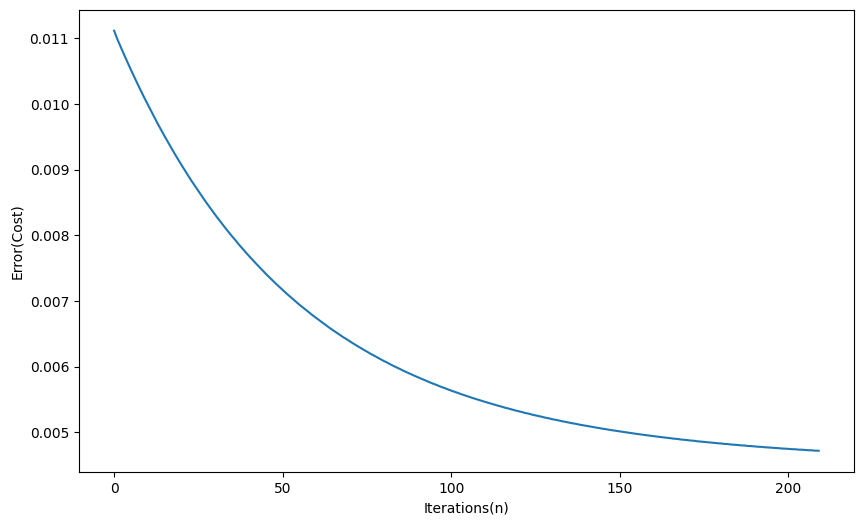

In [10]:
N = 4
D= 3
S = np.eye(3, 3)

X = gen_input_matrix(N, S)
w = np.random.normal(0, 0.1, 4)
t = gen_target_vector(X, w, 0.1)
t3 = gen_target_vector(X, w, 0.5)

S2 = np.eye(N*3-1, N*3-1)
X2 = gen_input_matrix(N*3, S2)
w2 = np.random.normal(0, 0.1, N*3)
t2 = gen_target_vector(X2, w2, 0.1)

theta, cost_history = gradient_descent_l1_l2(X,t)
theta3, cost_history3 = gradient_descent_l1_l2(X,t3)
theta2, cost_history2 = gradient_descent_l1_l2(X2,t2)

plt.figure(figsize=(10,6))
plt.plot(range(len(cost_history)), cost_history)
# plt.plot(range(len(cost_history3)), cost_history3)
plt.ylabel("Error(Cost)")
plt.xlabel("Iterations(n)")
plt.show()


# Todo: Add plots for all the weights values and how they change with iterations.

In [11]:
y = np.matmul(X, theta[1:]) + theta[0]
print(calculate_norm_rse(t, y))

2795.953912242524


In [13]:
from tqdm import tqdm # [2]


def nrmse_with_sigma(N=100, D=10, sigmas=[], alpha=0.01, lambda1=0.01, lambda2=0.01, plot=True):
    """Performs the experiment by varying sigma and calculating the average NRMSE over 5 runs."""
    
    nrmse_results = []
    
    for sigma in sigmas:
        nrmse_sum = 0
        
        for run in range(5):  
            S = np.eye(D,D)
            X = gen_input_matrix(N, S)
            true_w = np.random.normal(0,0.1,D + 1)  # Generate true weights (including bias)
            t = gen_target_vector(X, true_w, sigma)
            
            # Split into training and validation subsets
            train_size = int(0.8 * N)
            X_train, X_val = X[:train_size], X[train_size:]
            t_train, t_val = t[:train_size], t[train_size:]
            
            # Train using gradient descent
            w, _ = gradient_descent_l1_l2(X_train, t_train, alpha, lambda1, lambda2)
            
            # Validate and calculate predictions on validation set
            y_val = np.dot(X_val, w[1:]) + w[0]  # Compute predictions using learned weights
            
            # Calculate NRMSE on validation set
            nrmse_sum += calculate_norm_rse(t_val, y_val)
        
        # Average NRMSE over the 5 runs for the current sigma
        avg_nrmse = nrmse_sum / 5
        nrmse_results.append(avg_nrmse)

    # Plot NRMSE vs. Sigma
    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(sigmas, nrmse_results, marker='o')
        plt.xlabel('Noise Variance (σ)')
        plt.ylabel('Average NRMSE on Validation Set')
        plt.title('Average NRMSE vs. Noise Variance (σ)')
        plt.grid(True)
        plt.show()

    return nrmse_results



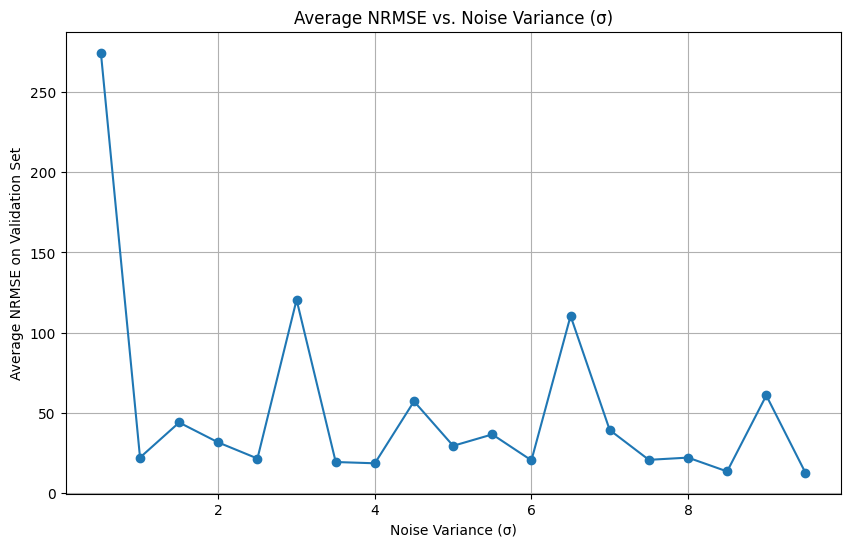

In [34]:
sigmas = [0.5*i for i in range(1,20)]
nrmse_results = nrmse_with_sigma(N=10, D=10, sigmas=sigmas)

In [14]:
def examine_nrmse_impact(N_values=None, lambda2_values=None, D=10, sigmas=[0.1], alpha=0.01, plot=True):
    """Examines the impact of N and λ2 on the NRMSE for linear regression using gradient descent.
    """
    
    if N_values is None:
        N_values = np.logspace(0, 4, 5, dtype=int)  # Sample sizes from 1 to 10,000
    if lambda2_values is None:
        lambda2_values = np.logspace(-3, 1, 5)  # Regularization values from 0.001 to 10

    results = {n: {} for n in N_values}

    for n in N_values:
        for lambda2 in lambda2_values:
            nrmse_sum = 0
            
            for run in range(5):  # Run the experiment 5 times
                S = np.eye(D, D)  
                X = gen_input_matrix(n, S)  # Function to generate input matrix
                true_w = np.random.normal(0, 0.1, D + 1) 
                t = gen_target_vector(X, true_w, sigmas[0])  # Generate target vector with noise
                
                # Split into training and validation subsets
                train_size = int(0.8 * n)
                X_train, X_val = X[:train_size], X[train_size:]
                t_train, t_val = t[:train_size], t[train_size:]
                
                # Train using gradient descent
                w, _ = gradient_descent_l1_l2(X_train, t_train, alpha, lambda1=0.01, lambda2=lambda2)
                
                # Validate and calculate predictions on validation set
                y_val = np.dot(X_val, w[1:]) + w[0]  # Compute predictions using learned weights
                
                # Calculate NRMSE on validation set
                nrmse_sum += calculate_norm_rse(t_val, y_val)

            # Average NRMSE over the 5 runs for the current (N, λ2) pair
            avg_nrmse = nrmse_sum / 5
            results[n][lambda2] = avg_nrmse

    
    if plot:
        plt.figure(figsize=(12, 8))
        for lambda2 in lambda2_values:
            avg_nrmse_list = [results[n][lambda2] for n in N_values]
            plt.plot(N_values, avg_nrmse_list, marker='o', label=f"λ2: {lambda2:.3f}")
        
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel("Sample Size (N)")
        plt.ylabel("Average NRMSE")
        plt.title("Impact of Sample Size (N) and λ2 on Average NRMSE")
        plt.legend()
        plt.grid(True)
        plt.show()

        heatmap_data = np.zeros((len(N_values), len(lambda2_values)))
        for i, n in enumerate(N_values):
            for j, lambda2 in enumerate(lambda2_values):
                heatmap_data[i, j] = results[n][lambda2]

        plt.figure(figsize=(12, 8))
        sns.heatmap(heatmap_data, annot=True, fmt=".2g", cmap='YlGnBu', 
                    xticklabels=[f"{l:.3f}" for l in lambda2_values],
                    yticklabels=N_values)
        
        plt.xlabel("Regularization Parameter (λ2)")
        plt.ylabel("Sample Size (N)")
        plt.title("Heatmap of Average NRMSE for Different Sample Sizes and Regularization Parameters")
        plt.show()

    return results

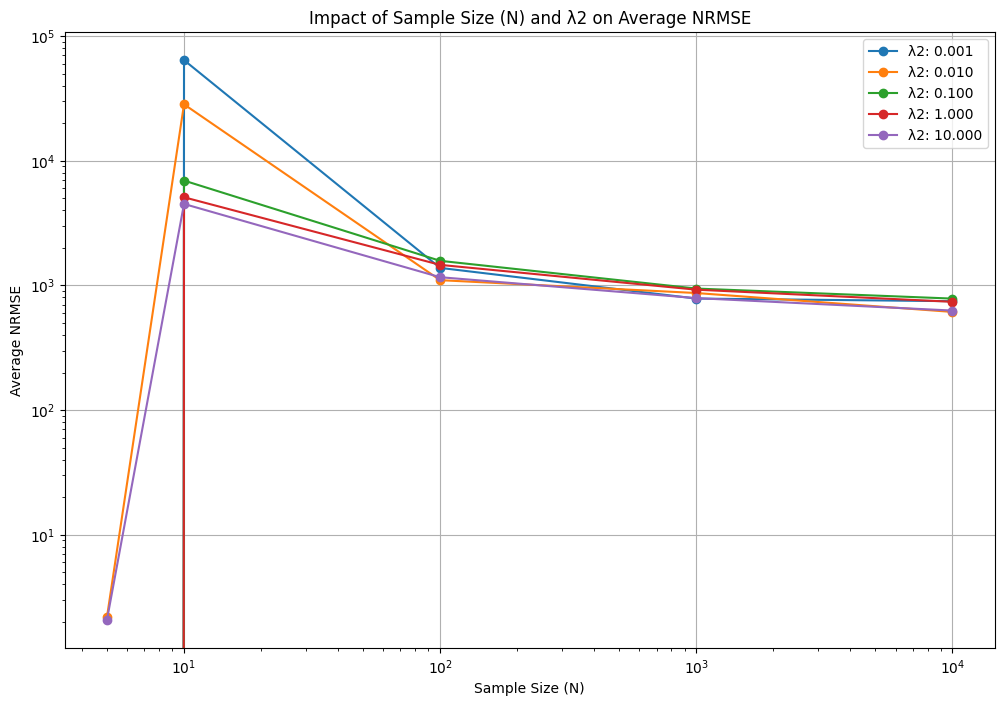

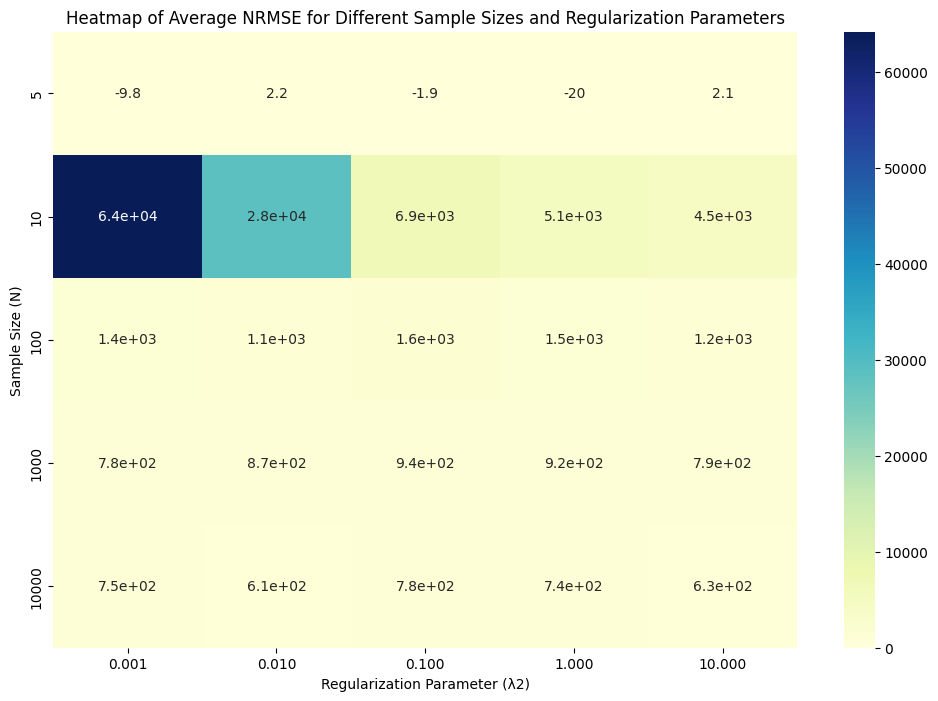

In [187]:
N = [5, 10, 100, 1000, 10000]
l2 = [0.001, 0.01, 0.1, 1.0, 10.0]
D = 100

        
results = examine_nrmse_impact(N, l2, D=10)



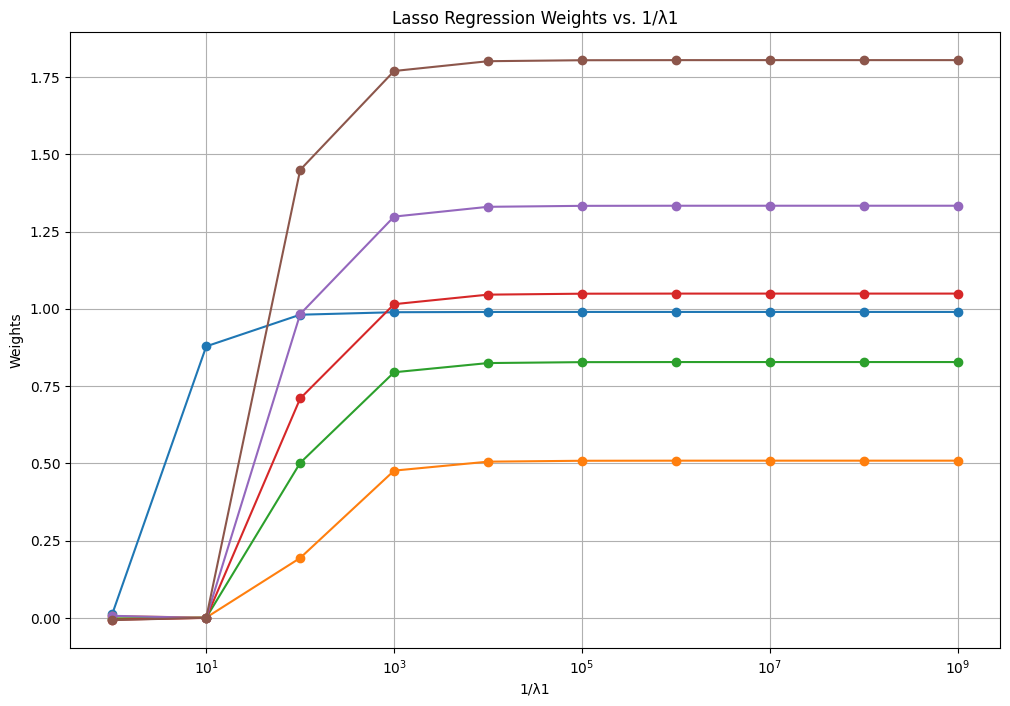

In [326]:
def lasso_variable_elimination(N=1000, D=5, lambda1_values=None, plot=True, correlation=False):
    """Examines the impact of λ1 on variable elimination using gradient descent for Lasso regression."""
    
    if lambda1_values is None:
        lambda1_values = np.logspace(-9, 0, 10)  # Regularization values from 0.001 to 10

    S = np.eye(D)  # Use an identity matrix for the generator matrix
    # X = gen_input_matrix(N, S)  # Generate input data matrix

    if correlation:
        X = gen_input_matrix(N, S)
        X[2, :] = X[1, :] + X[3, :]
        # X[2] = X[1] + X[3]

    else:
        X = gen_input_matrix(N, S)
  
        
    # true_w = np.random.normal(5, 0.1, D + 1)  # True weights (including bias)
    true_w = [(i+1) for i in range(D+1)]
    t = gen_target_vector(X, true_w, sigma=0.1)  # Generate target vector

    weights = []

    for lambda1 in lambda1_values:
        theta, _ = gradient_descent_l1_l2(X, t, alpha=0.01, max_iters=10000,lambda1=lambda1, lambda2=0.01)
        weights.append(theta)

   
    weights = np.array(weights)

    # Plot weights versus 1/λ1
    if plot:
        plt.figure(figsize=(12, 8))
        for i in range(weights.shape[1]):  # Iterate through weights
            plt.plot(1/lambda1_values, weights[:, i], marker='o')
        
        plt.xlabel('1/λ1')
        plt.ylabel('Weights')
        plt.title('Lasso Regression Weights vs. 1/λ1')
        plt.grid(True)
        
        plt.xscale('log')
        plt.show()

    return weights

# Call the function to perform the experiment with correlation
weights = lasso_variable_elimination()


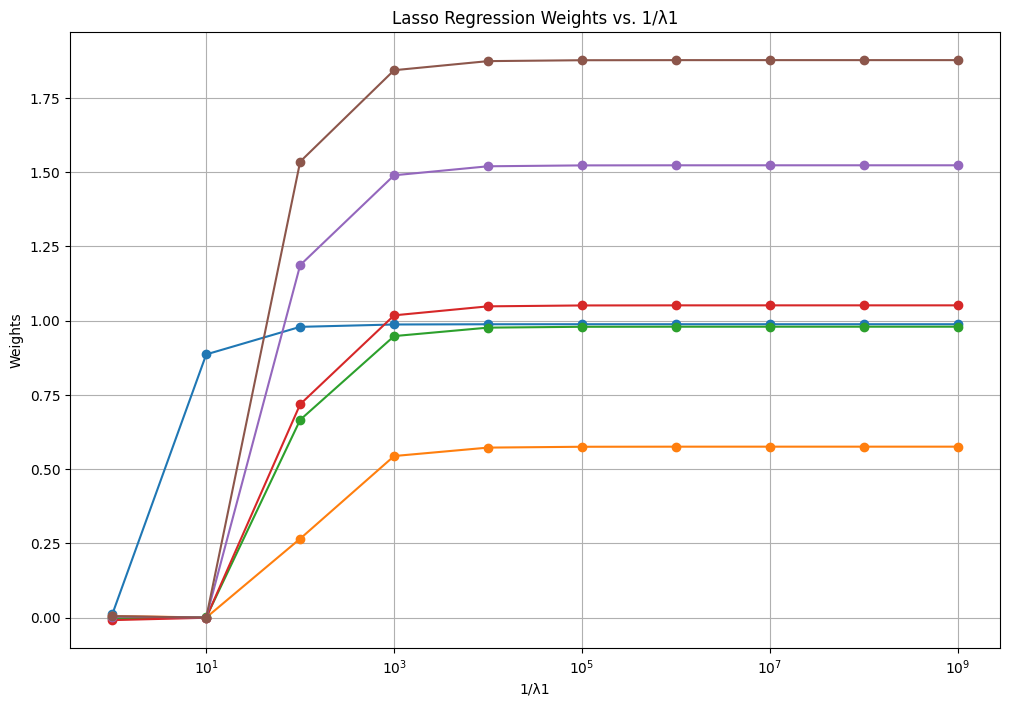

In [341]:
weights = lasso_variable_elimination(correlation=True)

### Observation:
We observe that the weights corresponding to the correlated columns tend to align closely, indicating that the regularization is promoting grouping behavior. 

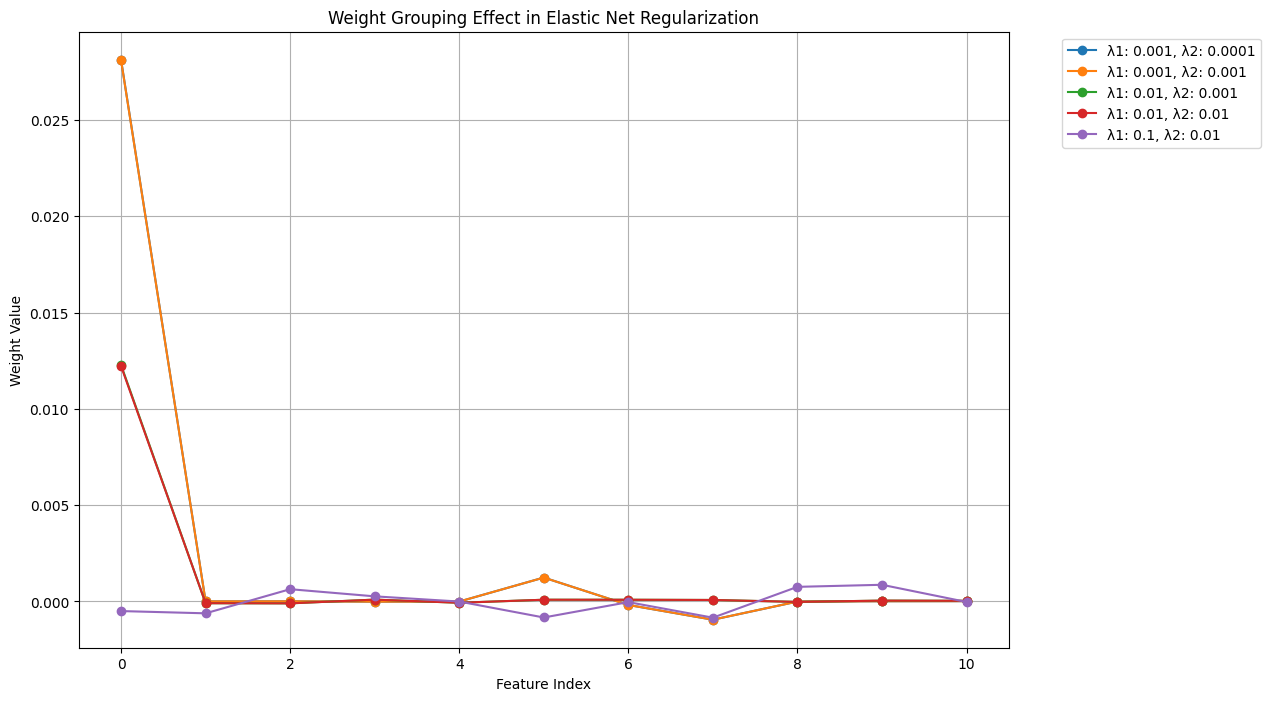

In [32]:
# Parameters
D = 10
N = 100  # Fixed sample size
alpha = 0.01  # Learning rate
sigmas = [0.1]
weights = []


lambda_pairs = [(0.001, 0.0001), (0.001, 0.001), (0.01, 0.001), (0.01, 0.01), (0.1, 0.01)]

# Generate input matrix and correlate columns
S = np.eye(D, D)
X = gen_input_matrix(N, S)
X[:, 1] = X[:, 0] + X[:, 2]  # Correlate 2nd column with 1st and 3rd

true_w = np.random.normal(0, 0.1, D + 1)
t = gen_target_vector(X, true_w, sigmas[0])

# Iterate over specific (lambda1, lambda2) pairs
for lambda1, lambda2 in lambda_pairs:
    # Perform gradient descent for Elastic Net
    theta, _ = gradient_descent_l1_l2(X, t, alpha=alpha, max_iters=10000, lambda1=lambda1, lambda2=lambda2)
    
    # Store weights for the current (lambda1, lambda2) pair
    weights.append((lambda1, lambda2, theta))

# Plot the grouping effect of weights for each (lambda1, lambda2) pair
plt.figure(figsize=(12, 8))
for i, (lambda1, lambda2, theta) in enumerate(weights):
    plt.plot(theta, marker='o', label=f"λ1: {lambda1}, λ2: {lambda2}")

plt.xlabel("Feature Index")
plt.ylabel("Weight Value")
plt.title("Weight Grouping Effect in Elastic Net Regularization")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()



In [15]:
def gen_binary_classification_vector(X, w, sigma=0.1):
    """Generates the binary classification vector t of size Nx1

    Parameters:
        X : Data matrix of size NxD
        w : weight vector of size (D+1,)
        sigma : noise variance (default is 0.1)

    Returns:
        t: [int]*N
    """
    
    X = np.array(X)  # Convert into np array if not already
    N, D = X.shape

    if not D + 1 == len(w):
        raise ValueError("Invalid weight vector, ensure the dimensions of X and w match.")

    t = np.matmul(X, w[1:])  # Calculate the linear combination
    bias = np.full(N, w[0])  # Create a bias array with the bias term
    noise = np.random.normal(0, sigma, N)  # Generate noise
    t = t + bias + noise  # Add bias and noise
    
    return np.where(t >= 0, 1, 0)  # Convert to binary labels

In [16]:
def gradient_binary_cross_entropy(X, y, w):
    """Computes the gradient of the binary cross-entropy loss for logistic regression.

    Parameters:
        X : Data matrix of size NxD (without bias column).
        y : Binary labels vector of size N.
        w : Weight vector of size (D+1,), including bias term.

    Returns:
        gradient : Gradient vector of size (D+1,)
    """
    N = X.shape[0]  # Number of samples
    X_biased = np.hstack((np.ones((N, 1)), X))  # Add bias term to input data
    predictions = 1 / (1 + np.exp(-np.dot(X_biased, w)))  # Sigmoid function

    # Compute the gradient
    gradient = (1 / N) * np.dot(X_biased.T, (predictions - y))

    return gradient


In [17]:
def sigmoid(z):
    """Compute the sigmoid function."""
    return 1 / (1 + np.exp(-z))

def gradient_descent_l1_l2_binary(X, y, alpha=0.01, lambda1=0.01, lambda2=0.01, max_iters=1000, tol=1e-6):
    """
    Perform gradient descent for binary classification with L1 (Lasso) and L2 (Ridge) regularization.
    """
    m, n = X.shape
    theta = np.zeros(n + 1)  # Initialize parameters (theta will be (n+1) due to the bias term)
    cost_history = []

    for iteration in range(max_iters):
        
        z = np.dot(X, theta[1:]) + theta[0]  # Compute the prediction: X @ theta[1:] + theta[0] for bias
        h = sigmoid(z)  # Apply the sigmoid function

        # Compute the error
        error = h - y

        gradient_mse = (1/m) * np.dot(X.T, error)  # Gradient of the binary cross-entropy
        gradient_w0 = (1/m) * np.sum(error)  # Gradient for the bias (theta[0])

        # L1 and L2 gradients
        gradient_l1 = lambda1 * np.sign(theta[1:])  # L1 regularization gradient
        gradient_l2 = 2 * lambda2 * theta[1:]  # L2 regularization gradient

        # Update the weights
        gradient_w = gradient_mse + gradient_l1 + gradient_l2
        theta[0] -= alpha * (gradient_w0)  # Update the bias term
        theta[1:] -= alpha * gradient_w  # Update the weights

        # Compute the cost function (cross-entropy + L1 + L2)
        cross_entropy_loss = - (1/m) * (np.dot(y, np.log(h + 1e-15)) + np.dot(1 - y, np.log(1 - h + 1e-15)))
        l1 = lambda1 * np.sum(np.abs(theta[1:]))  # L1 regularization
        l2 = lambda2 * np.sum(theta[1:] ** 2)  # L2 regularization
        cost = cross_entropy_loss + l1 + l2
        cost_history.append(cost)


        if iteration > 0 and abs(cost_history[-1] - cost_history[-2]) < tol:
            break

    return theta, cost_history

In [21]:
def examine_rmse_impact_binary(N_values=None, lambda2_values=None, D=10, sigmas=[0.1], alpha=0.01, plot=True):
    """Examines the impact of N (sample size) and λ2 (regularization parameter) on RMSE for binary classification using gradient descent."""
    
    # Set default values if none provided
    if N_values is None:
        N_values =np.logspace(0, 4, 5, dtype=int)
    if lambda2_values is None:
        lambda2_values = lambda2_values or np.logspace(-3, 1, 5)
    
    results = {n: {} for n in N_values}

    for n in N_values:
        for lambda2 in lambda2_values:
            rmse_sum = 0
            
            for _ in range(5):  # Perform 5 runs for averaging
                S = np.eye(D, D)
                X = gen_input_matrix(n, S)
                true_w = np.random.normal(0, 0.1, D + 1)
                t = gen_target_vector(X, true_w, sigmas[0])

                # Train-validation split (80-20)
                train_size = int(0.8 * n)
                X_train, X_val = X[:train_size], X[train_size:]
                t_train, t_val = t[:train_size], t[train_size:]
                
                # Train model using gradient descent
                w, _ = gradient_descent_l1_l2_binary(X_train, t_train, alpha, lambda1=0.01, lambda2=lambda2)
                
                # Compute validation predictions
                y_val = np.dot(X_val, w[1:]) + w[0]
                y_prob = 1 / (1 + np.exp(-y_val))  # Logistic function for probabilities

                # Compute RMSE for validation set
                rmse_sum += np.sqrt(np.mean((y_prob - t_val)**2))

            # Store average RMSE for current N and λ2
            results[n][lambda2] = rmse_sum / 5

    if plot:
        plot_rmse_results(N_values, lambda2_values, results)

    return results

def plot_rmse_results(N_values, lambda2_values, results):
    """Helper function to plot RMSE results."""
    
    # Line plot for RMSE
    plt.figure(figsize=(12, 8))
    for lambda2 in lambda2_values:
        rmse_list = [results[n][lambda2] for n in N_values]
        plt.plot(N_values, rmse_list, marker='o', label=f"λ2: {lambda2:.3f}")
    
    plt.xscale('log')
    plt.xlabel("Sample Size (N)")
    plt.ylabel("Average RMSE")
    plt.title("Impact of Sample Size (N) and λ2 on RMSE for Binary Classification")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Heatmap plot for RMSE
    heatmap_data = np.array([[results[n][lambda2] for lambda2 in lambda2_values] for n in N_values])
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".2g", cmap='YlGnBu',
                xticklabels=[f"{l:.3f}" for l in lambda2_values], yticklabels=N_values)
    
    plt.xlabel("Regularization (λ2)")
    plt.ylabel("Sample Size (N)")
    plt.title("Heatmap of Average RMSE for Binary Classification")
    plt.show()

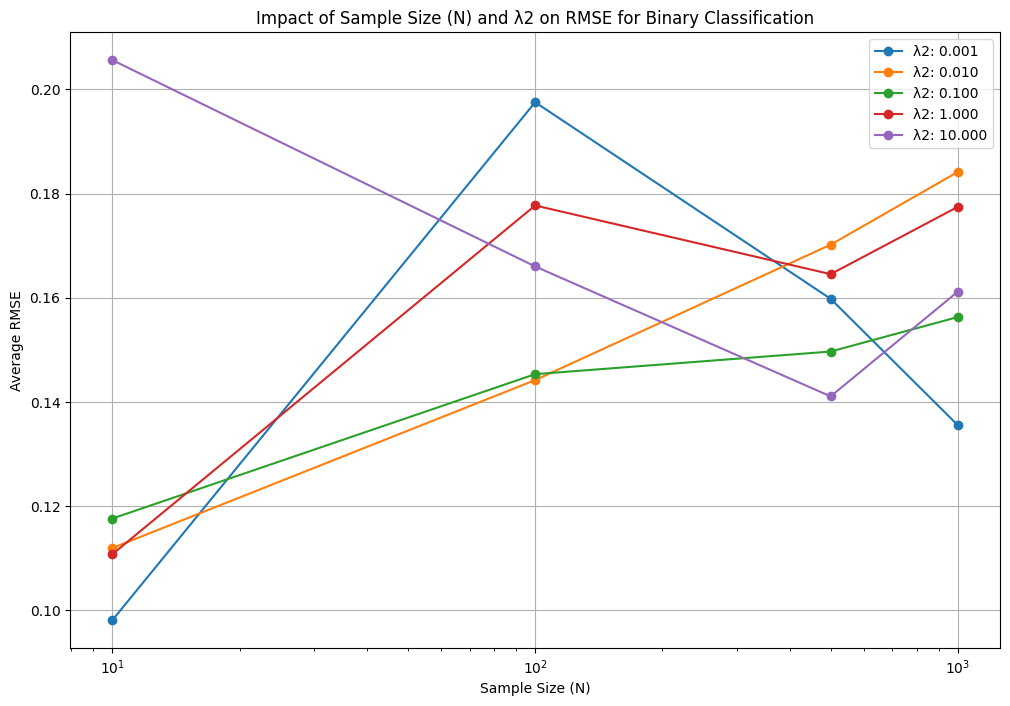

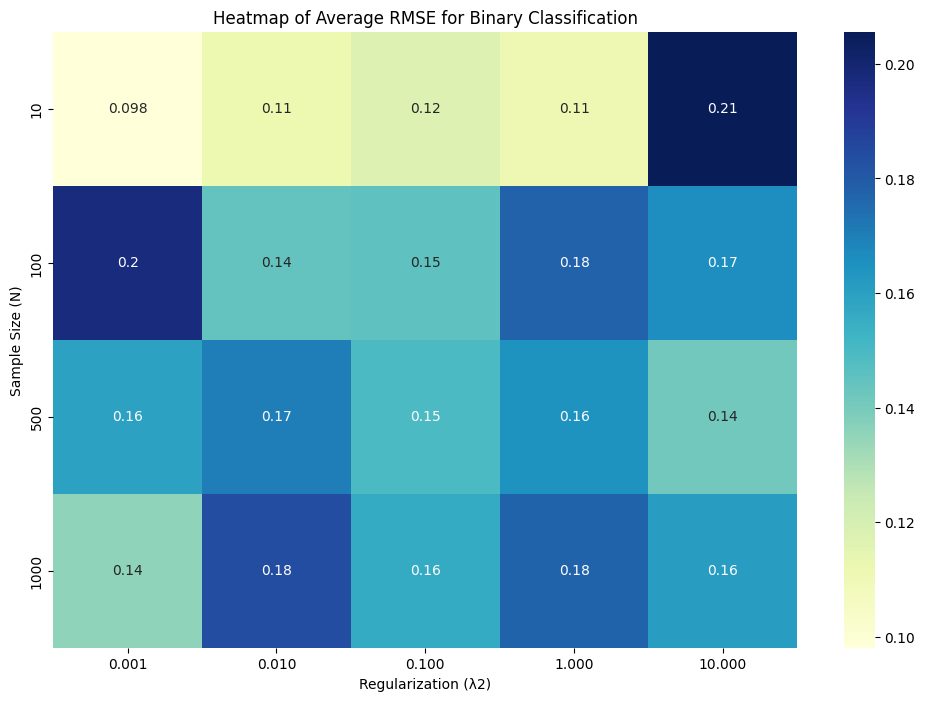

{10: {np.float64(0.001): np.float64(0.09811812129465744),
  np.float64(0.01): np.float64(0.11196136090065104),
  np.float64(0.1): np.float64(0.11762436533707639),
  np.float64(1.0): np.float64(0.1107815510811098),
  np.float64(10.0): np.float64(0.20561010212105463)},
 100: {np.float64(0.001): np.float64(0.1975255242392002),
  np.float64(0.01): np.float64(0.14419389079583755),
  np.float64(0.1): np.float64(0.14532913645976314),
  np.float64(1.0): np.float64(0.17771208978803638),
  np.float64(10.0): np.float64(0.1660068429876152)},
 500: {np.float64(0.001): np.float64(0.15979609305653245),
  np.float64(0.01): np.float64(0.17018169122959162),
  np.float64(0.1): np.float64(0.1496733390854183),
  np.float64(1.0): np.float64(0.16452806696967967),
  np.float64(10.0): np.float64(0.14106552165472847)},
 1000: {np.float64(0.001): np.float64(0.135520327469334),
  np.float64(0.01): np.float64(0.18416068118556356),
  np.float64(0.1): np.float64(0.1562975806338453),
  np.float64(1.0): np.float64(0.1

In [22]:
N_values = [10, 100, 500, 1000]
lambda2_values = np.logspace(-3, 1, 5)
examine_rmse_impact_binary(N_values, lambda2_values)

## References Used
[* ] Resource Used for Formulating the Gradient - [Stack Exchange](https://math.stackexchange.com/questions/1962877/compute-the-gradient-of-mean-square-error)<br>
[* ] How to write multiline Latex in code cell - [Stack OverFlow](https://stackoverflow.com/questions/13208286/how-to-write-latex-in-ipython-notebook)<br>
[* ] For many functions that are written above: ChatGPT Prompt: Write the docstring for this function - _function definition_

[1.] Discussion with friends and on the whatsApp group about the approach for the stopping criterion.<br>
[2.] Progress Bar in Python for loops: [Stack OverFlow](https://stackoverflow.com/questions/3160699/python-progress-bar)<br>
[3. ] Grouping Effect in Elastic Net  - [Research Gate](https://www.researchgate.net/publication/267465100_On_grouping_effect_of_elastic_net)